In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import json
import ast
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import dataframe_image as dfi
import gensim
from gensim.models.doc2vec import Doc2Vec
import sent2vec
from sklearn.linear_model import LogisticRegression

In [53]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [52]:
price_test = pd.read_csv('./Bitcoin_price_test.csv', index_col=0)
conditions = [
    ((price_test['Close'] - price_test['Open']) < -100),
    ((price_test['Close'] - price_test['Open']) > -100) & ((price_test['Close'] - price_test['Open']) < 100),
    ((price_test['Close'] - price_test['Open']) > 100)
    ]
values = [-1, 0, 1]
price_test['label'] = np.select(conditions, values)

In [53]:
price_test

,Open,High,Low,Close,Volume,date,year,month,day,hour,label
2021-10-11 02:00:00+00:00,55412.207031,55790.500000,55370.359375,55790.500000,0,2021-10-11 02:00:00+00:00,2021,10,11,2,1
2021-10-11 03:00:00+00:00,55818.210938,56652.300781,55721.574219,56476.230469,1132040192,2021-10-11 03:00:00+00:00,2021,10,11,3,1
2021-10-11 04:00:00+00:00,56529.949219,56715.328125,56390.179688,56469.457031,1766322176,2021-10-11 04:00:00+00:00,2021,10,11,4,0
2021-10-11 05:00:00+00:00,56473.832031,56587.890625,56203.863281,56546.843750,0,2021-10-11 05:00:00+00:00,2021,10,11,5,0
2021-10-11 06:00:00+00:00,56535.332031,56728.453125,56535.332031,56728.453125,2315206656,2021-10-11 06:00:00+00:00,2021,10,11,6,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11 19:00:00+00:00,64801.242188,65213.804688,64801.242188,65114.726562,0,2021-11-11 19:00:00+00:00,2021,11,11,19,1
2021-11-11 20:00:00+00:00,65087.613281,65224.218750,64782.183594,64782.183594,0,2021-11-11 20:00:00+00:00,2021,11,11,20,-1
2021-11-11 21:00:00+00:00,64824.214844,65125.527344,64737.449219,65072.550781,0,2021-11-11 21:00:00+00:00,2021,11,11,21,1
2021-11-11 22:00:00+00:00,65110.792969,65302.222656,64948.136719,65196.500000,0,2021-11-11 22:00:00+00:00,2021,11,11,22,0


In [54]:
tweet_test = pd.read_csv('./Bitcoin_tweets_test.csv', index_col=0)

/opt/anaconda3/envs/540/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [55]:
def load_json(x):
    x = ast.literal_eval(x)
    return x['compound']
tweet_test['score'] = tweet_test['sentiments'].apply(load_json)

In [56]:
tweet_test

,date,user_followers,user_friends,text,month,day,hour,sentiments,score
91598,2021-10-11 02:59:55+00:00,3949.0,3836.0,leash might popular shiba inu dogecoin still l...,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'comp...",0.4215
91615,2021-10-11 02:59:32+00:00,9216.0,10818.0,land expand look like zoom expand even excitin...,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.34, 'pos': 0.66, 'compou...",0.9118
91623,2021-10-11 02:59:23+00:00,34693.0,172.0,launch around cornerwould want get presalejoin...,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.0772
91629,2021-10-11 02:59:18+00:00,34873.0,5804.0,short fiat long ltv ratio oh also deposit,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
91630,2021-10-11 02:59:17+00:00,2300.0,0.0,buy alarm minute chartprice coin,10.0,11.0,2.0,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400
...,...,...,...,...,...,...,...,...,...
2694030,2021-11-11 23:00:03+00:00,2552.0,2233.0,btc g act open btc total,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2694035,2021-11-11 23:00:02+00:00,9847.0,477.0,hyperdeflationary money explosive increase pur...,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.3182
2694038,2021-11-11 23:00:02+00:00,1717.0,38.0,go back time see data inc market cap size,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2694040,2021-11-11 23:00:01+00:00,13575.0,10756.0,wanna moonwillionaire watch official music vid...,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [63]:
def get_pred_majority(df):
    conditions = [df['score'] < 0, df['score'] == 0, df['score'] > 0]
    choices = [-1, 0, 1]
    preds = np.select(conditions, choices)
    index = np.argmax([preds.tolist().count(-1), preds.tolist().count(0), preds.tolist().count(1)])
    return [-1, 0, 1][index]

def get_pred_by_follower(df):
    conditions = [df['score'] < 0, df['score'] == 0, df['score'] > 0]
    choices = [-1, 0, 1]
    df['pred'] = np.select(conditions, choices)
    count = df[['pred', 'user_followers']].groupby('pred').sum()
    return count.index[count['user_followers'].argmax()]

def get_pred_by_friends(df):
    conditions = [df['score'] < 0, df['score'] == 0, df['score'] > 0]
    choices = [-1, 0, 1]
    df['pred'] = np.select(conditions, choices)
    count = df[['pred', 'user_friends']].groupby('pred').sum()
    return count.index[count['user_friends'].argmax()]

func = [get_pred_majority, get_pred_by_follower, get_pred_by_friends]
accs = []
f11 = []
f12 = []
for i in range(3):
    price_test['pred'] = np.nan
    for m, d, h in tweet_test.groupby(['month','day', 'hour'], as_index=False).groups:
        if math.isnan(m): continue
        df = tweet_test.loc[(tweet_test['hour']==h) & (tweet_test['month']==m) & (tweet_test['day']==d)]
        pred = func[i](df)
        price_test.loc[(price_test['hour']==h) & (price_test['month']==m) & (price_test['day']==d), 'pred'] = pred
    accs.append(accuracy_score(price_test['label'], price_test['pred']))
    f11.append(f1_score(price_test['label'], price_test['pred'], average='macro'))
    f12.append(f1_score(price_test['label'], price_test['pred'], average='micro'))

/opt/anaconda3/envs/540/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/540/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
pd.DataFrame({'accuracy': accs, 'macro f1': f11, 'micro f1': f12}, 
             index=['By Majority', 'By user_followers', 'By user_friends'])

,accuracy,macro f1,micro f1
By Majority,0.322414,0.260916,0.322414
By user_followers,0.313793,0.259736,0.313793
By user_friends,0.306897,0.243699,0.306897


In [41]:
tweet_train = pd.read_csv('./Bitcoin_tweets_train.csv', index_col=0)
tweet_test = pd.read_csv('./Bitcoin_tweets_test.csv', index_col=0)
tweet_test.dropna(subset = ["text"], inplace=True)
tweet_train.dropna(subset = ["text"], inplace=True)
tweet_test

/opt/anaconda3/envs/540/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,user_followers,user_friends,text,month,day,hour,sentiments
91598,2021-10-11 02:59:55+00:00,3949.0,3836.0,leash might popular shiba inu dogecoin still lead dog pack highest price among dog,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'compound': 0.4215}"
91615,2021-10-11 02:59:32+00:00,9216.0,10818.0,land expand look like zoom expand even exciting impressive land read http,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.34, 'pos': 0.66, 'compound': 0.9118}"
91623,2021-10-11 02:59:23+00:00,34693.0,172.0,launch around cornerwould want get presalejoin telegram amp get voi,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.0772}"
91629,2021-10-11 02:59:18+00:00,34873.0,5804.0,short fiat long ltv ratio oh also deposit,10.0,11.0,2.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
91630,2021-10-11 02:59:17+00:00,2300.0,0.0,buy alarm minute chartprice coin,10.0,11.0,2.0,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.34}"
...,...,...,...,...,...,...,...,...
2694030,2021-11-11 23:00:03+00:00,2552.0,2233.0,btc g act open btc total,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2694035,2021-11-11 23:00:02+00:00,9847.0,477.0,hyperdeflationary money explosive increase purchasing power followed mild correction attrac,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.3182}"
2694038,2021-11-11 23:00:02+00:00,1717.0,38.0,go back time see data inc market cap size,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2694040,2021-11-11 23:00:01+00:00,13575.0,10756.0,wanna moonwillionaire watch official music video podcast dont,11.0,11.0,23.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [7]:
def load_json(x):
    x = ast.literal_eval(x)
    return x['compound']
tweet_train['score'] = tweet_train['sentiments'].apply(load_json)
tweet_test['score'] = tweet_test['sentiments'].apply(load_json)

In [72]:
short_tweet_train = tweet_train[tweet_train['user_followers']>1500]

In [3]:
price_train = pd.read_csv('./Bitcoin_price_train.csv', index_col=0)
conditions = [
    ((price_train['Close'] - price_train['Open']) < -100),
    ((price_train['Close'] - price_train['Open']) > -100) & ((price_train['Close'] - price_train['Open']) < 100),
    ((price_train['Close'] - price_train['Open']) > 100)
    ]
values = [-1, 0, 1]
price_train['label'] = np.select(conditions, values)

price_test = pd.read_csv('./Bitcoin_price_test.csv', index_col=0)
conditions = [
    ((price_test['Close'] - price_test['Open']) < -100),
    ((price_test['Close'] - price_test['Open']) > -100) & ((price_test['Close'] - price_test['Open']) < 100),
    ((price_test['Close'] - price_test['Open']) > 100)
    ]
values = [-1, 0, 1]
price_test['label'] = np.select(conditions, values)
price_train

,Open,High,Low,Close,Volume,date,year,month,day,hour,label
2021-02-05 10:00:00+00:00,37378.046875,37568.921875,37254.945312,37397.636719,0,2021-02-05 10:00:00+00:00,2021,2,5,10,0
2021-02-05 11:00:00+00:00,37391.320312,37663.328125,37378.425781,37604.191406,0,2021-02-05 11:00:00+00:00,2021,2,5,11,1
2021-02-05 12:00:00+00:00,37608.269531,38035.390625,37550.179688,37887.941406,715452416,2021-02-05 12:00:00+00:00,2021,2,5,12,1
2021-02-05 13:00:00+00:00,37889.402344,38205.437500,37792.796875,38205.437500,1043619840,2021-02-05 13:00:00+00:00,2021,2,5,13,1
2021-02-05 14:00:00+00:00,38204.816406,38225.906250,38032.015625,38103.242188,637046784,2021-02-05 14:00:00+00:00,2021,2,5,14,-1
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26 18:00:00+00:00,46969.625000,47070.667969,46777.898438,47009.554688,0,2021-08-26 18:00:00+00:00,2021,8,26,18,0
2021-08-26 19:00:00+00:00,47004.257812,47025.253906,46791.078125,46962.960938,0,2021-08-26 19:00:00+00:00,2021,8,26,19,0
2021-08-26 20:00:00+00:00,46939.375000,47046.296875,46888.398438,47012.277344,160188416,2021-08-26 20:00:00+00:00,2021,8,26,20,0
2021-08-26 21:00:00+00:00,47032.632812,47315.992188,47032.632812,47268.570312,84576256,2021-08-26 21:00:00+00:00,2021,8,26,21,1


In [27]:
# vectorizer = TfidfVectorizer(max_features=1000)
# vectorizer.fit(tweet_train['text'])

# d2v = Doc2Vec.load('doc2vec_50.model')

sent2v = sent2vec.Sent2vecModel()
sent2v.load_model('./twitter_unigrams.bin', inference_mode=True)

In [28]:
def by_concat(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.minute > 30]
    text = ' '.join(df['text'])
    result = vectorizer.transform([text])
    return result

def use_dev2vec(df):
    text = ' '.join(df['text'])
    text = text.split(' ')
    result = d2v.infer_vector(text)
    return result

def use_sent2vec(df):
    text = ' '.join(df['text'])
    result = sent2v.embed_sentence(text)[0]
    return result

def tf_idf_by_follower(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.minute > 30]
    df['follower_weight'] = df['user_followers'] / np.sum(df['user_followers'])
    vectors = df.apply(lambda x: vectorizer.transform([x['text']]) * x['follower_weight'], axis=1)
    return vectors.sum()

def sent2vec_by_follower(df):
    df['follower_weight'] = df['user_followers'] / np.sum(df['user_followers'])
    vectors = df.apply(lambda x: sent2v.embed_sentence(x['text'])[0] * x['follower_weight'], axis=1)
    return vectors.sum()

def get_sentiment(df):
    avg_mean = np.array(df['score'].to_list()).mean()
    return avg_mean

def transform_data(tweet, price, trans_func):
    tweet_vector = []
    price_label = []
    for m, d, h in tqdm(tweet.groupby(['month','day', 'hour'], as_index=False).groups):
        if math.isnan(m): continue
        df = tweet.loc[(tweet['hour']==h) & (tweet['month']==m) & (tweet['day']==d)]
        label = price.loc[(price['hour']==h) & (price['month']==m) & 
                                (price['day']==d)]['label'].tolist()[0]
        tweet_vector.append(trans_func(df))
        price_label.append(label)
        
    tweet_vector = np.vstack(tweet_vector)
    price_label = np.array(price_label)
    tweet_vector = tweet_vector
    price_label = price_label
    return tweet_vector, price_label

In [29]:
train_vector, train_label = transform_data(tweet_train, price_train, sent2vec_by_follower)
test_vector, test_label = transform_data(tweet_test, price_test, sent2vec_by_follower)

  0%|                                                                                                                                                    | 0/1366 [00:00<?, ?it/s]/opt/anaconda3/envs/540/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 581/581 [01:49<00:00,  5.30it/s]


In [10]:
def trans(vector, label, i):
    l = [vector[i:,:]]
    for j in range(i):
        j = j + 1
        l.append(np.reshape(label[(i-j):-j], (-1,1)))
    X = np.concatenate(l, axis=1)
    y = label[i:]
    return X, y

In [15]:
l = []
for i in range(1, 240):
    X, y = trans(train_vector, train_label, i)
    X_test, y_test = trans(test_vector, test_label, i)
    clf = LogisticRegression(random_state=0).fit(X, y)
    l.append(clf.score(X_test, y_test))
l = np.array(l)

In [11]:
X, y = trans(train_vector, train_label, 13)
X_test, y_test = trans(test_vector, test_label, 13)
clf = LogisticRegression(random_state=0).fit(X, y)
print(clf.score(X_test, y_test))
pred = clf.predict(X_test)
print(f1_score(y_test, pred, average='macro'))

0.400352733686067
0.36994246926836505


In [18]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'accuracy')

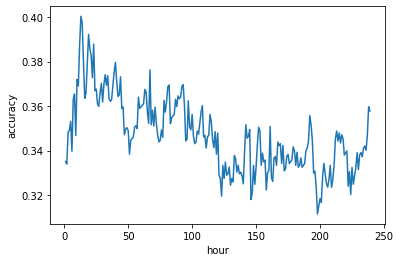

In [21]:
plt.plot(range(1, 240), l)
plt.xlabel('hour')
plt.ylabel('accuracy')

In [64]:
train_vector, train_label = train_vector[:-1], train_label[1:]
test_vector, test_label = test_vector[:-1], test_label[1:]

In [49]:
def create_model(model):
    if model == 'GradientBoosting':
        clf = GradientBoostingClassifier(random_state=0)
    if model == 'LinearSVC':
        clf = LinearSVC(random_state=0, max_iter=100000)
    if model == 'DecisionTree':
        clf = DecisionTreeClassifier(random_state=0)
    if model == 'RandomForest':
        clf = RandomForestClassifier(random_state=0)
    if model == 'KNeighbors':
        clf = KNeighborsClassifier()
    if model == 'MLP':
        clf = MLPClassifier(random_state=0, max_iter=1000)
    return clf

In [50]:
models = ['GradientBoosting', 'LinearSVC', 'DecisionTree', 'RandomForest', 'KNeighbors', 'MLP']
table = []
for model in tqdm(models):
    clf = create_model(model)
    clf.fit(train_vector, train_label)
    pred = clf.predict(test_vector)
    acc = accuracy_score(test_label, pred)
    f1 = f1_score(test_label, pred, average='macro')
    table.append([acc, f1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:44<00:00, 17.47s/it]


In [51]:
pd.DataFrame(table, columns=['Accuracy', 'F-measure'], index=models)

,Accuracy,F-measure
GradientBoosting,0.465517,0.456421
LinearSVC,0.418966,0.400126
DecisionTree,0.363793,0.354983
RandomForest,0.360345,0.356724
KNeighbors,0.322414,0.310199
MLP,0.382759,0.372824


In [44]:
dfi.export(pd.DataFrame(table, columns=['Accuracy', 'F-measure'], index=models), f'table_doc2vec_50_lag1.png')

[1120/235727.297933:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/n5/_g8c3nb52234gdnms8crl9bm0000gn/T/: Operation not permitted (1)
[1120/235727.304971:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[1120/235727.310098:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/n5/_g8c3nb52234gdnms8crl9bm0000gn/T/: Operation not permitted (1)
[1120/235728.308661:INFO:headless_shell.cc(653)] Written to file /var/folders/n5/_g8c3nb52234gdnms8crl9bm0000gn/T/tmpxg0q417j/temp.png.


In [30]:
clf = LinearSVC(random_state=0, max_iter=100000).fit(train_vector, train_label)
pred = clf.predict(test_vector)
accuracy_score(test_label, pred)

0.4086206896551724

In [68]:
test_label

580

In [14]:
pred_time_series

567

In [20]:
pred_gb_greater_30

580

In [25]:
pred_gb_tfidf_followers_greater_30

580

In [31]:
pred_svc_sent2v_follower

In [103]:
def z_score(pred, label):
    pred = pred == label
    pred = pred.astype(int)
    
    mean = np.mean(pred)
    std = np.std(pred)
    z = (mean - 0.36) / (std/np.sqrt(len(pred)))
    return z


z_scores = [z_score(p, test_label[13:]) for p in [pred_time_series, pred_gb_greater_30[13:],
                                      pred_gb_tfidf_followers_greater_30[13:],
                                      pred_svc_sent2v_follower[13:], preds]]

In [104]:
acc_with_ensem = [accuracy_score(preds, p) for p in [pred_time_series, pred_gb_greater_30[13:],
                                      pred_gb_tfidf_followers_greater_30[13:],
                                      pred_svc_sent2v_follower[13:], preds]]

In [108]:
acc_label = [accuracy_score(test_label[13:], p) for p in [pred_time_series, pred_gb_greater_30[13:],
                                      pred_gb_tfidf_followers_greater_30[13:],
                                      pred_svc_sent2v_follower[13:], preds]]

In [115]:
pd.DataFrame({'z_score_0.36': z_scores, 'accuracy_to_label': acc_label, 
              'accuracy_to_ensemble':acc_with_ensem}, index=[
    'time series', 'tf_idf_after_30_GB', 'tf_idf_follower_after_30_GB', 'sent2vec_follower_svc', 'ensemble'
])

,z_score_0.36,accuracy_to_label,accuracy_to_ensemble
time series,1.961079,0.400353,0.463845
tf_idf_after_30_GB,4.958435,0.463845,0.661376
tf_idf_follower_after_30_GB,3.963681,0.442681,0.724868
sent2vec_follower_svc,2.213487,0.405644,0.657848
ensemble,5.789348,0.481481,1.000000


In [32]:
from scipy import stats
preds = stats.mode(np.vstack([pred_gb_greater_30[13:], 
                      pred_gb_tfidf_followers_greater_30[13:], pred_svc_sent2v_follower[13:],
                             pred_time_series])).mode[0]

In [33]:
accuracy_score(test_label[13:], preds)

0.48148148148148145

In [91]:
accuracy_score(preds, pred_svc_sent2v_follower[13:])

0.6578483245149912

In [36]:
import pickle
with open('ensemble_result.pkl', 'wb') as f:
    pickle.dump(preds, f)

In [9]:
import pickle
with open('ensemble_result.pkl', 'rb') as f:
    preds = pickle.load(f)

In [18]:
df = price_test[13:]
df['pred'] = preds

/opt/anaconda3/envs/540/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df["outcome"] = df['label'] == df['pred']
df = df[df['outcome']==False]

/opt/anaconda3/envs/540/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
import matplotlib.pyplot as plt

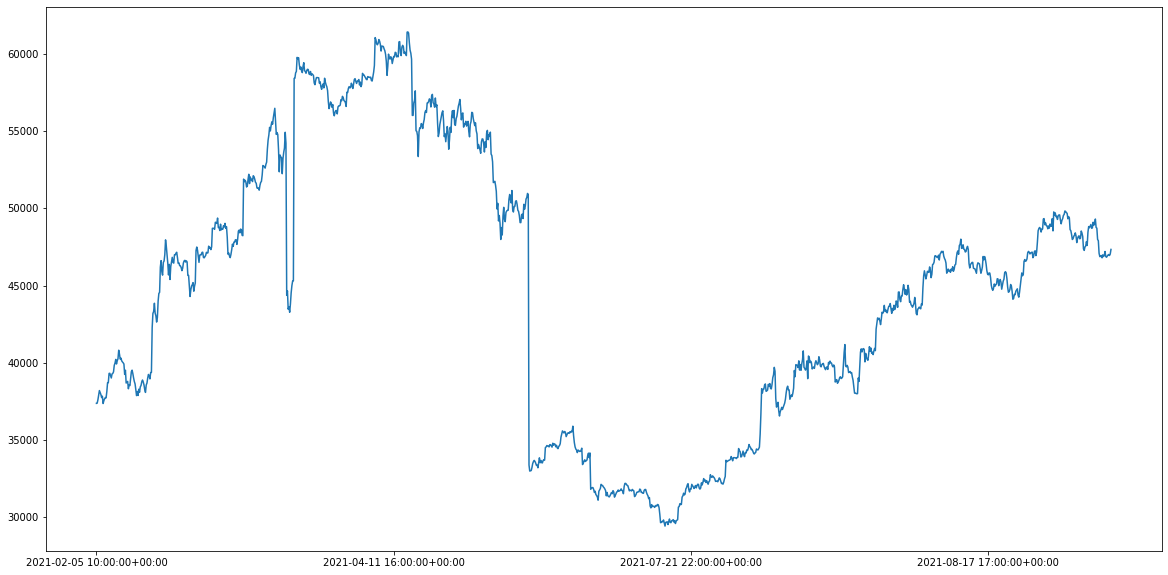

In [28]:
price_train['Open'].plot(figsize=(20, 10)).locator_params(axis="x", nbins=9)

AttributeError: 'AxesSubplot' object has no attribute 'autofmt_xdate'

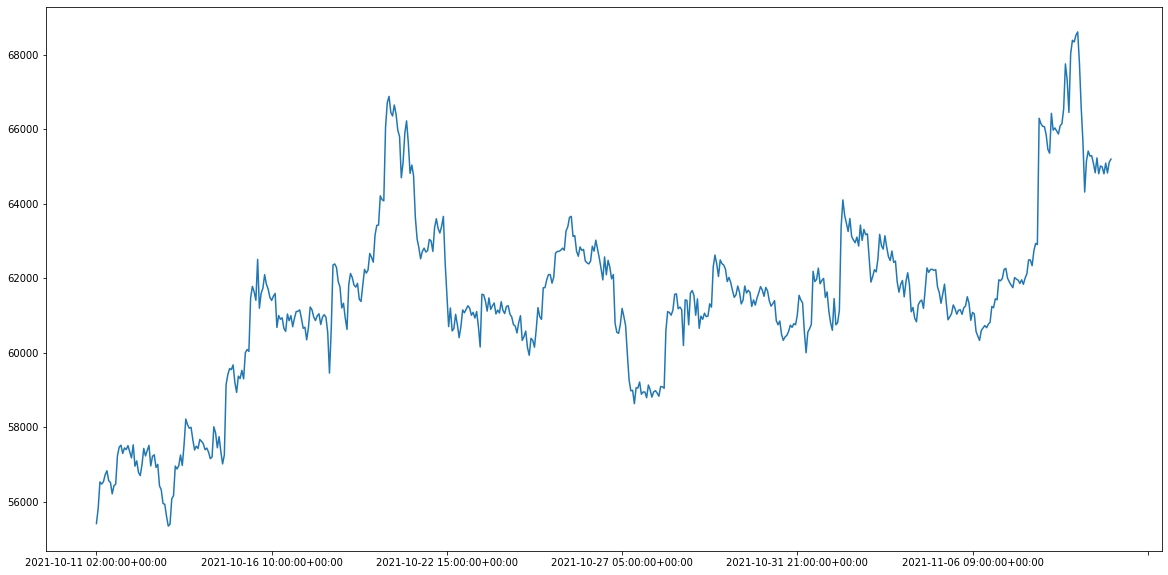

In [71]:
price_test['Open'].plot(style='-',figsize=(20, 10))

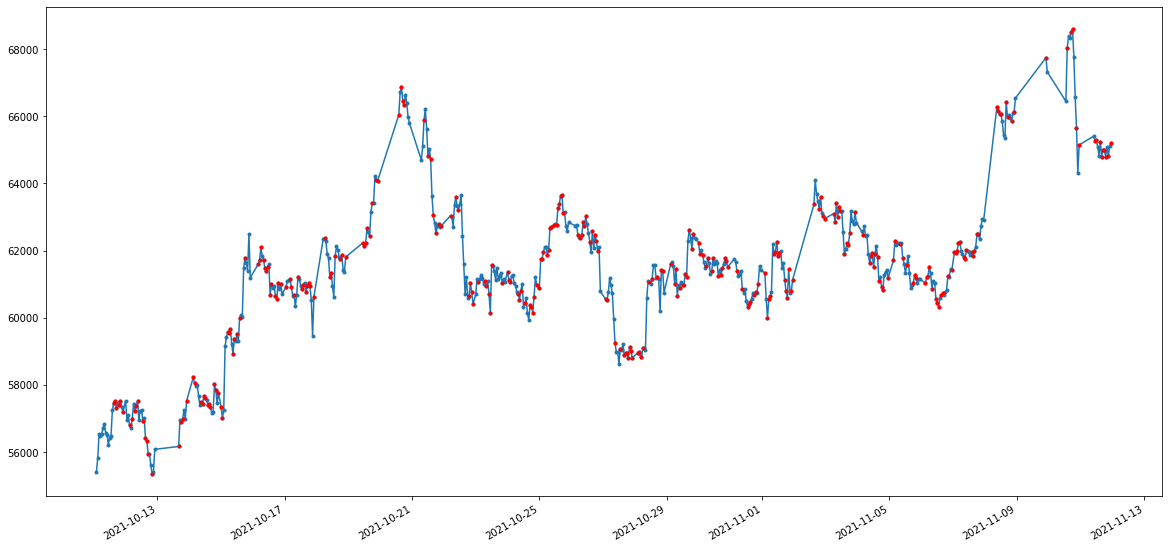

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(pd.to_datetime(price_test.index).to_pydatetime(), price_test['Open'], '.-')
plt.plot(pd.to_datetime(df.index).to_pydatetime(), df['Open'], '.r')
plt.gcf().autofmt_xdate()

In [55]:
tweet_test[(tweet_test['month']==10) & (tweet_test['day']==17) & (tweet_test['hour']==4)]

,date,user_followers,user_friends,text,month,day,hour,sentiments
834812,2021-10-17 04:59:57+00:00,16699.0,391.0,impossible understand dont spend time understand importance sound money doesnt,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}"
834824,2021-10-17 04:59:46+00:00,2010.0,1982.0,exchanged bitcoin dogecoin april thth bitcoin wa k st time w,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
834834,2021-10-17 04:59:38+00:00,3415.0,864.0,succeed hopefully shrug maxi,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'compound': 0.7096}"
834868,2021-10-17 04:59:17+00:00,19303.0,7.0,srm long positionv entry price targetstop,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
834869,2021-10-17 04:59:15+00:00,16261.0,7910.0,one greatest projectcozz nice ico strong team management,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.327, 'pos': 0.673, 'compound': 0.8834}"
834871,2021-10-17 04:59:14+00:00,3074.0,4979.0,spot currently guy asked free party popperlikerttag,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.7184}"
834878,2021-10-17 04:59:09+00:00,2670.0,259.0,cant stop studying chart chart,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'compound': 0.2235}"
834879,2021-10-17 04:59:09+00:00,5502.0,3431.0,good night crypto twitter trixiexpr vet,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}"
834882,2021-10-17 04:59:07+00:00,22768.0,375.0,shib token giveawayi give million shib token random people follow retweettag friendsle,10.0,17.0,4.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
834886,2021-10-17 04:59:02+00:00,4696.0,1924.0,mark cuban doesnt understand give u greater freedom fiat billionaire enjoy today,10.0,17.0,4.0,"{'neg': 0.121, 'neu': 0.457, 'pos': 0.423, 'compound': 0.7423}"
